In [1]:
%load_ext autoreload
%autoreload 2

# import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
import numpy as np
from copy import deepcopy
import uproot
from hepattn.experiments.clic.performance.performance import Performance
from hepattn.experiments.clic.performance.plot_helper_event import *
from hepattn.experiments.clic.performance.plot_helper_particle import *
import matplotlib.pyplot as plt

In [3]:
save_dir = 'maskformer_infer_best'
SAVE_FIG = False

In [4]:
os.makedirs(save_dir, exist_ok=True)

In [4]:
net_dict = {
    'mpflow' : '/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_Full_20250607-T234846/ckpts/epoch=082-val_loss=5.71306__test.root',
    # 'hgpflow' : '/storage/agrp/nilotpal/HGPFlow_v2/experiments/hgpflow_v2/clicxminixbig1x2xs2xxxds7kirm1yo/inference/ee_qq_new/pred_test_p8_ee_qq_ecm380_20k_seg_bw0.3_nocut_merged.root',
    # 'hgpflow'
}

In [5]:
perf_obj = Performance(
    # truth_path='/storage/agrp/dmitrykl/hgpf/hepformer/data/nilo/test_clic_common_raw.root',
    truth_path='/storage/agrp/dmitrykl/hgpf/hepformer/data/nilo/test_clic_raw.root',
    networks=net_dict,
    # num_events=18000,
    # num_events={
    #     'mpflow' : 25_000,
    # }
)

E, pT will be scaled by 1


Reading truth tree...: 100%|██████████| 11/11 [00:02<00:00,  5.10it/s]


Number of events with at least one track or topocluster: 24999 out of 25000
[[17479]]
Number of events after filtering: 24999


Computing mpflow mass...: 100%|██████████| 24728/24728 [00:00<00:00, 58010.15it/s]


In [6]:
perf_obj.reorder_and_find_intersection()

common event count: 24728


Filtering truth...:   0%|          | 0/14 [00:00<?, ?it/s]

Filtering and reordering mpflow...: 100%|██████████| 12/12 [00:00<00:00, 2037.80it/s]


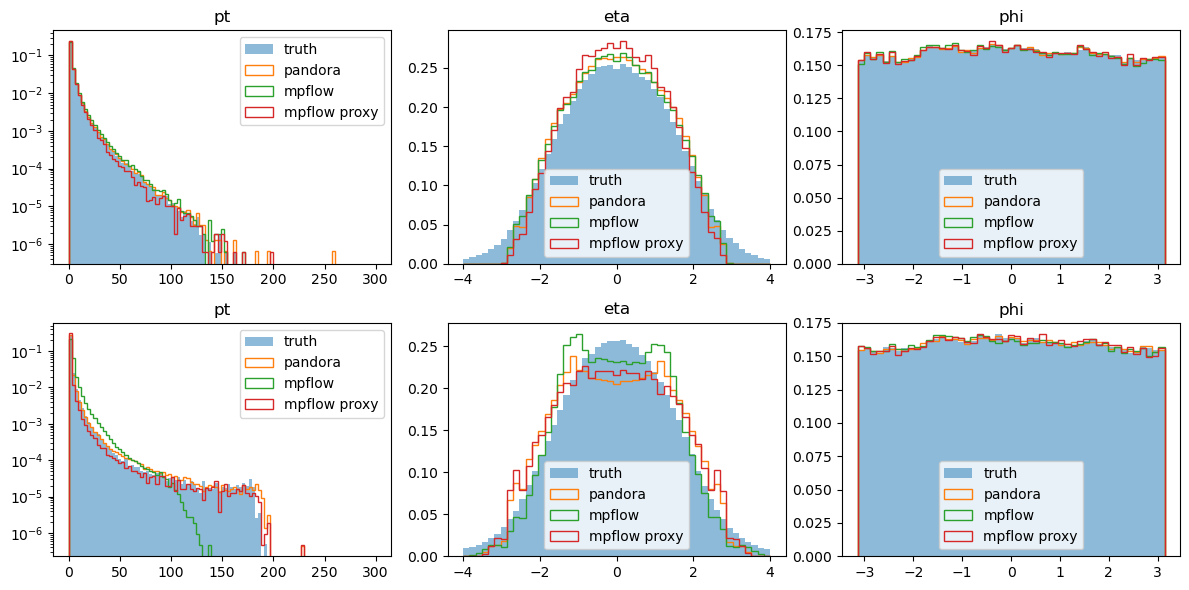

In [7]:
bins = [
    np.linspace(0, 300, 100),
    np.linspace(-4, 4, 50),
    np.linspace(-np.pi, np.pi, 50),
]
var_names = ["pt", "eta", "phi"]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
mask_fns = [
    lambda x: x < 3,
    lambda x: (x < 5) & (x > 2),
]
truth_class = np.concatenate(perf_obj.truth_dict['particle_class'])
pandora_class = np.concatenate(perf_obj.truth_dict['pandora_class'])

for i in range(3):
    for j in range(2):
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict['particle_' + var_names[i]])[mask_fns[j](truth_class)],
            bins=bins[i],
            histtype="stepfilled",
            alpha=0.5,
            label="truth",
            density=True,
        )
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict['pandora_' + var_names[i]])[mask_fns[j](pandora_class)],
            bins=bins[i],
            histtype="step",
            label="pandora",
            density=True,
        )
        for key, value in perf_obj.data.items():
            pf_class = np.concatenate(value[f'class'])
            ax[j, i].hist(
                np.concatenate(value[var_names[i]])[mask_fns[j](pf_class)],
                bins=bins[i],
                histtype="step",
                label=key,
                density=True,
            )
            if key in {'hgpflow', 'mpflow'}:
                ax[j, i].hist(
                    np.concatenate(value['proxy_' + var_names[i]])[mask_fns[j](pf_class)],
                    bins=bins[i],
                    histtype="step",
                    label=key + " proxy",
                    density=True,
                )
        ax[j, i].set_title(var_names[i])
        ax[j, i].legend()
        ax[j, 0].set_yscale("log")

plt.tight_layout()
plt.show()



In [8]:
def get_n_particles(data_dict, key='class'):
    n_charged = []
    n_neutral = []
    for i in range(len(data_dict[key])):
        ch_mask = data_dict[key][i] <= 2
        n_charged.append(np.sum(ch_mask))
        n_neutral.append(np.sum(~ch_mask))
    return np.array(n_charged), np.array(n_neutral)


In [9]:
n_charged_truth, n_neutral_truth = get_n_particles(perf_obj.truth_dict, key='particle_class')
n_charged_pandora, n_neutral_pandora = get_n_particles(perf_obj.truth_dict, key='pandora_class')

for key in perf_obj.data.keys():
    n_charged, n_neutral = get_n_particles(perf_obj.data[key])
    perf_obj.data[key]['n_charged'] = n_charged
    perf_obj.data[key]['n_neutral'] = n_neutral

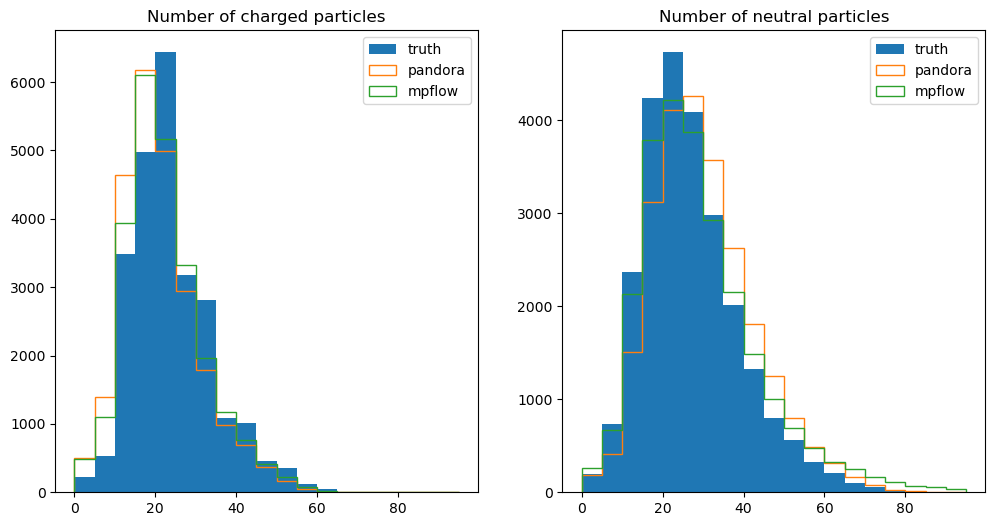

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(n_charged_truth, bins=np.arange(0, 100, 5), histtype='stepfilled', label='truth')
ax[1].hist(n_neutral_truth, bins=np.arange(0, 100, 5), histtype='stepfilled', label='truth')
ax[0].hist(n_charged_pandora, bins=np.arange(0, 100, 5), histtype='step', label='pandora')
ax[1].hist(n_neutral_pandora, bins=np.arange(0, 100, 5), histtype='step', label='pandora')
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]['n_charged'], perf_obj.data[key]['n_neutral']
    ax[0].hist(n_charged, bins=np.arange(0, 100, 5), histtype='step', label=key)
    ax[1].hist(n_neutral, bins=np.arange(0, 100, 5), histtype='step', label=key)
ax[0].legend()
ax[1].legend()
ax[0].set_title('Number of charged particles')
ax[1].set_title('Number of neutral particles')
plt.show()

In [11]:
from scipy.stats import iqr

In [12]:
def _add_hist(ax, data, bins, label, histtype='step', **kwargs):
    mean, iqr_ = np.mean(data), iqr(data)
    label = f"{label}: $\mu$={mean:.2f}, iqr={iqr_:.2f}"
    ax.hist(data, bins=bins, histtype=histtype, label=label, **kwargs)

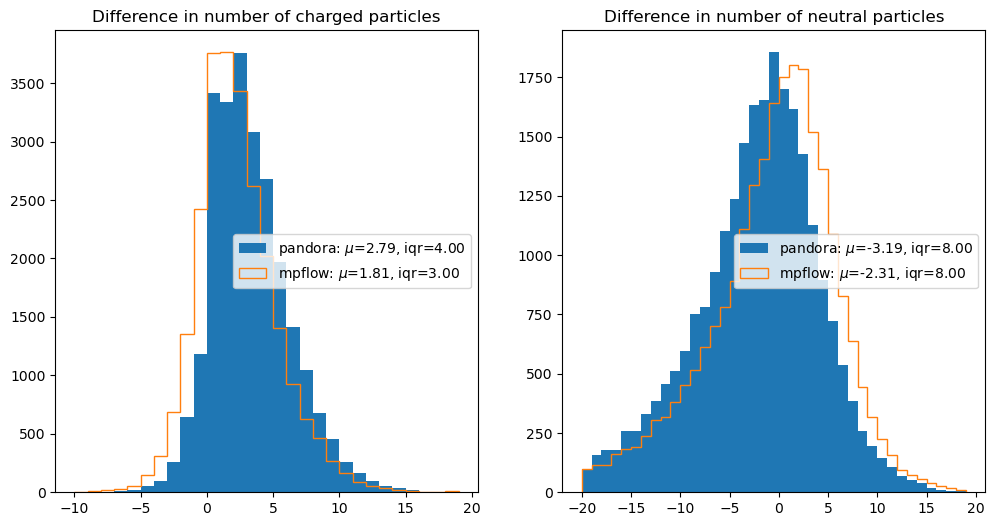

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
_add_hist(
    ax[0],
    n_charged_truth - n_charged_pandora,
    bins=np.arange(-10, 20, 1),
    histtype='stepfilled',
    label='pandora'
)
_add_hist(
    ax[1],
    n_neutral_truth - n_neutral_pandora,
    bins=np.arange(-20, 20, 1),
    histtype='stepfilled',
    label='pandora'
)
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]['n_charged'], perf_obj.data[key]['n_neutral']
    _add_hist(
        ax[0],
        n_charged_truth - n_charged,
        bins=np.arange(-10, 20, 1),
        label=key,
        histtype='step'
    )
    _add_hist(
        ax[1],
        n_neutral_truth - n_neutral,
        bins=np.arange(-20, 20, 1),
        label=key,
        histtype='step'
    )
ax[0].legend()
ax[1].legend()
ax[0].set_title('Difference in number of charged particles')
ax[1].set_title('Difference in number of neutral particles')
plt.show()

(array([ 456., 2791., 7972., 6778., 3254., 1821.,  933.,  472.,  198.,
          53.]),
 array([  0. ,  14.8,  29.6,  44.4,  59.2,  74. ,  88.8, 103.6, 118.4,
        133.2, 148. ]),
 <BarContainer object of 10 artists>)

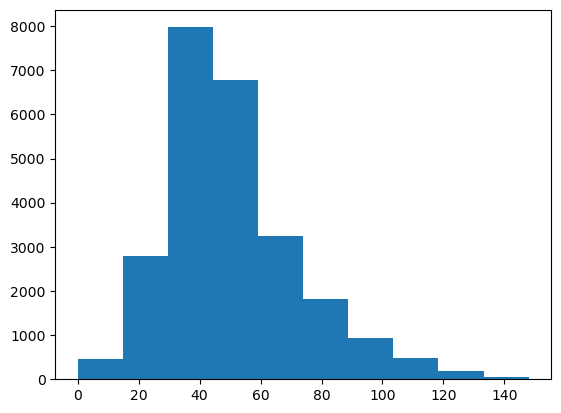

In [14]:
plt.hist(n_charged + n_neutral)

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [17]:
perf_obj.data['hgpflow']['eta'] = perf_obj.data['hgpflow']['proxy_eta']
perf_obj.data['hgpflow']['phi'] = perf_obj.data['hgpflow']['proxy_phi']
perf_obj.data['hgpflow']['pt'] = perf_obj.data['hgpflow']['proxy_pt']

for i in range(len(perf_obj.data['hgpflow']['pt'])):
    ch_mask = perf_obj.data['hgpflow']['class'][i] <= 2
    perf_obj.data['hgpflow']['pt'][i][ch_mask] = perf_obj.data['hgpflow']['proxy_pt'][i][ch_mask]

KeyError: 'hgpflow'

In [17]:
idx = 0

print("Particle data")
print(np.sort(perf_obj.truth_dict['particle_pt'][idx][perf_obj.truth_dict['particle_class'][idx] <= 2])[::-1])
print("MPflow proxy data")
print(np.sort(perf_obj.data['mpflow']['proxy_pt'][idx][perf_obj.data['mpflow']['class'][idx] <= 2])[::-1])
# print("HGPflow proxy data")
# print(np.sort(perf_obj.data['hgpflow']['proxy_pt'][idx][perf_obj.data['hgpflow']['class'][idx] <= 2])[::-1])

Particle data
[22.68040657  9.80447769  4.84874296  3.93368745  3.68394566  3.14503121
  2.60827255  2.39196706  2.09633183  1.96743882  1.35374236  1.34088707
  1.14111745  1.00602424  0.70337182  0.70083827  0.68998379  0.63668203
  0.44614998  0.09880546]
MPflow proxy data
[13.377591    9.781012    4.839227    4.0573926   3.6415377   3.1533294
  2.363066    1.9732016   1.9732016   1.3599572   1.1239315   1.0143477
  0.719316    0.719316    0.719316    0.6322116   0.43903565  0.25358716]


In [19]:
with uproot.open("/storage/agrp/dmitrykl/hgpf/hepformer/data/nilo/test_clic_common_infer.root")  as f:
    track_pt = f['EventTree']['track_pt'].array(library='np')

KeyboardInterrupt: 

In [ ]:
track_pt[0]

array([2.0557632 , 2.0023131 , 1.2279536 , 0.9496677 , 0.94607526,
       0.6072147 , 0.57421523, 0.52669734, 0.45971552, 0.45850766,
       0.26150492, 0.14520171, 0.23455974, 0.22790611, 0.183785  ,
       1.2232844 , 0.3203548 , 0.5793999 , 0.5837239 ], dtype=float32)

In [18]:
perf_obj.compute_jets(n_procs=20)
perf_obj.match_jets()

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7
truth
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|▏         | 27/1236 [00:00<00:04, 269.98it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   1%|          | 15/1236 [00:00<00:08, 149.37it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

Computing jets...:   7%|▋         | 85/1236 [00:00<00:04, 282.45it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|▏         | 22/1237 [00:00<00:05, 214.24it/s]]

Jet clustering algorithm:  #--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#-------------------------------------------

Computing jets...:   8%|▊         | 97/1236 [00:00<00:03, 345.39it/s]

Computing jets...:  21%|██▏       | 265/1236 [00:00<00:02, 384.61it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|██▏       | 272/1237 [00:00<00:02, 399.06it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------

Computing jets...:  29%|██▉       | 359/1237 [00:00<00:02, 405.99it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|▊         | 105/1236 [00:00<00:03, 346.72it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  18%|█▊        | 228/1237 [00:00<00:02, 382.53it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

Computing jets...:  39%|███▉      | 486/1237 [00:01<00:01, 405.37it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:   9%|▊         | 107/1237 [00:00<00:03, 364.66it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|▊         | 103/1236 [00:00<00:03, 348.64it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  45%|████▌     | 557/1236 [00:01<00:01, 386.91it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

Computing jets...:  19%|█▊        | 230/1237 [00:00<00:02, 391.96it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|▊         | 105/1236 [00:00<00:03, 359.20it/s]

Jet clustering algorithm:  genkt
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#-------------------------------------

Computing jets...:   8%|▊         | 103/1236 [00:00<00:03, 362.53it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  67%|██████▋   | 833/1236 [00:02<00:01, 384.37it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: #--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------

Computing jets...:  14%|█▍        | 179/1236 [00:00<00:02, 370.96it/s]]

Jet clustering algorithm:  

Computing jets...:  35%|███▍      | 427/1237 [00:01<00:02, 388.21it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  77%|███████▋  | 951/1236 [00:02<00:00, 371.82it/s]]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

Computing jets...:  25%|██▌       | 315/1237 [00:00<00:02, 404.40it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  44%|████▍     | 541/1236 [00:01<00:01, 371.22it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  57%|█████▋    | 701/1236 [00:02<00:01, 333.26it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  53%|█████▎    | 660/1236 [00:01<00:01, 382.24it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  95%|█████████▍| 1171/1237 [00:03<00:00, 378.74it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

Computing jets...: 100%|██████████| 1237/1237 [00:03<00:00, 384.54it/s]


Jet clustering algorithm:  pandora
genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▎         | 44/1236 [00:00<00:02, 435.65it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 41/1236 [00:00<00:02, 405.68it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  14%|█▍        | 174/1236 [00:00<00:02, 408.58it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  13%|█▎        | 166/1236 [00:00<00:02, 390.27it/s]

Jet clustering algorithm: 

Computing jets...:  10%|▉         | 122/1237 [00:00<00:02, 405.26it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  24%|██▍       | 294/1236 [00:00<00:02, 380.13it/s]

Jet clustering algorithm:  genkt

Computing jets...:  10%|▉         | 123/1236 [00:00<00:02, 399.51it/s]


Jet clustering radius:  0.7


Computing jets...:  20%|██        | 249/1237 [00:00<00:02, 396.59it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   0%|          | 0/1237 [00:00<?, ?it/s]390.93it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  30%|███       | 375/1237 [00:00<00:02, 405.21it/s]

Jet clustering algorithm:  genkt

Computing jets...:  10%|▉         | 120/1236 [00:00<00:02, 385.08it/s]


Jet clustering radius:  0.7


Computing jets...:  10%|▉         | 121/1237 [00:00<00:02, 386.39it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  47%|████▋     | 579/1237 [00:01<00:01, 389.01it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  53%|█████▎    | 658/1237 [00:01<00:01, 383.45it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  24%|██▎       | 292/1237 [00:00<00:02, 404.63it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  59%|█████▊    | 724/1236 [00:01<00:01, 384.15it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|▉         | 113/1237 [00:00<00:02, 374.86it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  26%|██▌       | 322/1236 [00:00<00:02, 371.65it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|██▏       | 275/1237 [00:00<00:02, 397.75it/s]]

Jet clustering algorithm:  

Computing jets...:  11%|█         | 132/1237 [00:00<00:03, 347.26it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  62%|██████▏   | 765/1237 [00:02<00:01, 388.75it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  79%|███████▊  | 973/1236 [00:02<00:00, 379.44it/s]]

Jet clustering algorithm: 

Computing jets...:  53%|█████▎    | 652/1237 [00:01<00:02, 252.64it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:   9%|▉         | 112/1236 [00:00<00:05, 195.50it/s]]

Jet clustering algorithm:  genkt

Computing jets...:   5%|▍         | 57/1237 [00:00<00:06, 181.98it/s]


Jet clustering radius:  0.7


Computing jets...: 100%|██████████| 1237/1237 [00:03<00:00, 381.41it/s]


Jet clustering algorithm:  mpflow jets
genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 36/1236 [00:00<00:03, 355.23it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 36/1236 [00:00<00:03, 357.30it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   0%|          | 0/1236 [00:00<?, ?it/s]342.35it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|▊         | 103/1237 [00:00<00:03, 331.24it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  18%|█▊        | 217/1236 [00:00<00:02, 348.13it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  17%|█▋        | 209/1237 [00:00<00:02, 342.69it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  20%|██        | 251/1237 [00:00<00:02, 338.26it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  19%|█▊        | 231/1236 [00:00<00:03, 322.99it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  33%|███▎      | 414/1236 [00:01<00:02, 334.70it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  34%|███▍      | 424/1237 [00:01<00:02, 330.32it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  56%|█████▌    | 687/1236 [00:02<00:01, 341.46it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   5%|▌         | 67/1236 [00:00<00:03, 334.69it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  24%|██▍       | 300/1237 [00:00<00:03, 302.90it/s]

Jet clustering algorithm:  genkt


Computing jets...:  64%|██████▍   | 789/1236 [00:02<00:01, 318.82it/s]

Jet clustering radius:  0.7


Computing jets...:  25%|██▌       | 310/1236 [00:00<00:03, 296.35it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  26%|██▋       | 327/1237 [00:00<00:02, 329.45it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  44%|████▍     | 550/1236 [00:01<00:02, 292.02it/s]

 0.7


Computing jets...:  75%|███████▌  | 930/1236 [00:02<00:00, 320.28it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   6%|▌         | 71/1236 [00:00<00:04, 252.05it/s]]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  60%|██████    | 743/1236 [00:02<00:02, 226.47it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   7%|▋         | 92/1236 [00:00<00:03, 320.60it/s]]]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  18%|█▊        | 223/1236 [00:00<00:04, 213.86it/s]

 0.7


Computing jets...: 100%|██████████| 1237/1237 [00:04<00:00, 297.97it/s]


Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 37/1236 [00:00<00:03, 366.73it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 36/1236 [00:00<00:03, 358.23it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   6%|▌         | 72/1236 [00:00<00:03, 359.04it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|▊         | 108/1236 [00:00<00:03, 336.15it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  15%|█▍        | 185/1236 [00:00<00:03, 348.95it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|▊         | 103/1237 [00:00<00:03, 345.32it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  23%|██▎       | 289/1236 [00:00<00:02, 323.27it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  19%|█▉        | 235/1236 [00:00<00:02, 334.57it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  28%|██▊       | 351/1237 [00:01<00:02, 329.15it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|▊         | 100/1236 [00:00<00:03, 307.60it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  50%|████▉     | 614/1236 [00:01<00:01, 336.05it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  46%|████▌     | 563/1237 [00:01<00:02, 331.22it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|▊         | 101/1237 [00:00<00:03, 322.93it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  33%|███▎      | 407/1236 [00:01<00:02, 333.44it/s]

Jet clustering algorithm:  genkt

Computing jets...:  20%|██        | 249/1236 [00:00<00:02, 338.52it/s]


Jet clustering radius:  0.7


Computing jets...:  55%|█████▌    | 682/1236 [00:02<00:01, 329.79it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  58%|█████▊    | 716/1236 [00:02<00:01, 293.85it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  80%|███████▉  | 986/1236 [00:02<00:00, 348.74it/s]

 0.7


Computing jets...:  72%|███████▏  | 889/1236 [00:02<00:01, 333.82it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  25%|██▍       | 308/1237 [00:00<00:03, 303.28it/s]]

Jet clustering algorithm:  

Computing jets...:  40%|████      | 500/1237 [00:01<00:02, 325.43it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  80%|████████  | 992/1236 [00:03<00:00, 316.26it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Matching jets...: 100%|██████████| 24728/24728 [00:00<00:00, 54972.51it/s]


### Jet residual plots

In [19]:
_dict = {
    'pandora': perf_obj.truth_dict['matched_pandora_jets'],
    # 'mlpf': perf_obj.mlpf_dict['matched_mlpf_jets'],
    'mpflow': perf_obj.data['mpflow']['matched_jets'],
    'proxy': perf_obj.data['mpflow']['matched_proxy_jets'],
    # 'hgpflow': perf_obj.data['hgpflow']['matched_proxy_jets'],
    # 'hgpflow_target': perf_obj.data['hgpflow_target']['matched_jets'],
}

jet_residual_dict = compute_jet_residual_dict(_dict, dr_cut=0.1, leading_N_jets=2, pt_min=10)

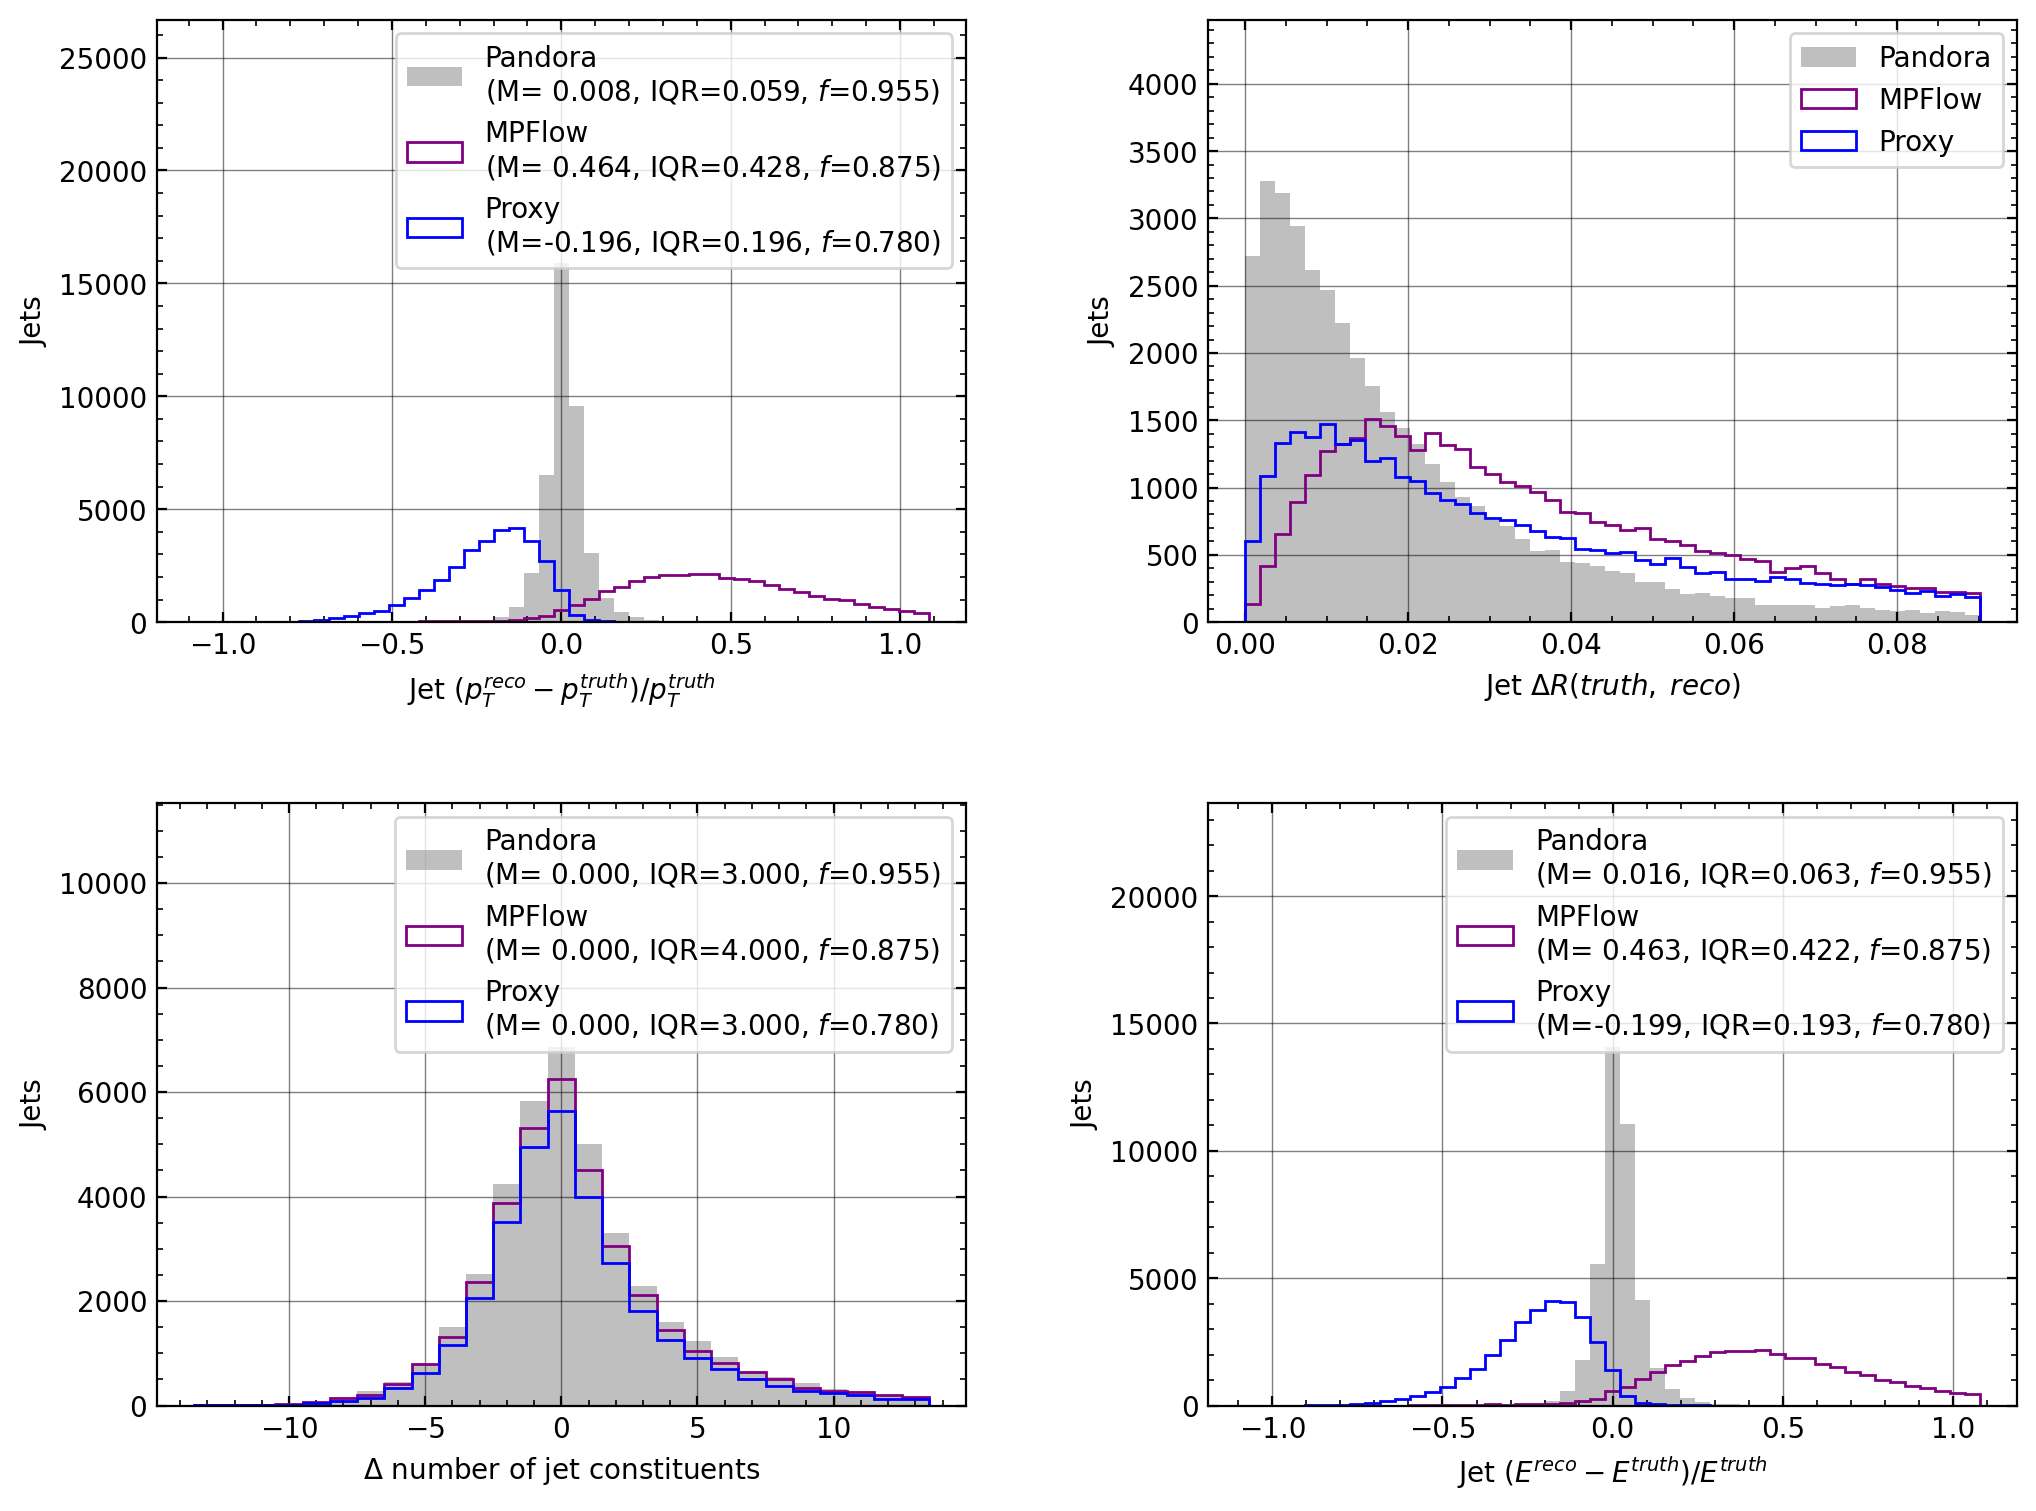

In [20]:
# change the x_lims

figs = plot_jet_residuals(jet_residual_dict, pt_relative=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f'{save_dir}/clic_dijet_jet_residuals_pt.png', dpi=300)
        figs[1].savefig(f'{save_dir}/clic_dijet_jet_residuals_dr.png', dpi=300)
        figs[2].savefig(f'{save_dir}/clic_dijet_jet_residuals_constcount.png', dpi=300)
        figs[3].savefig(f'{save_dir}/clic_dijet_jet_residuals_e.png', dpi=300)
    else:
        figs.tight_layout()
        figs.savefig(f'{save_dir}/clic_dijet_jet_residuals.png', dpi=300, bbox_inches='tight')

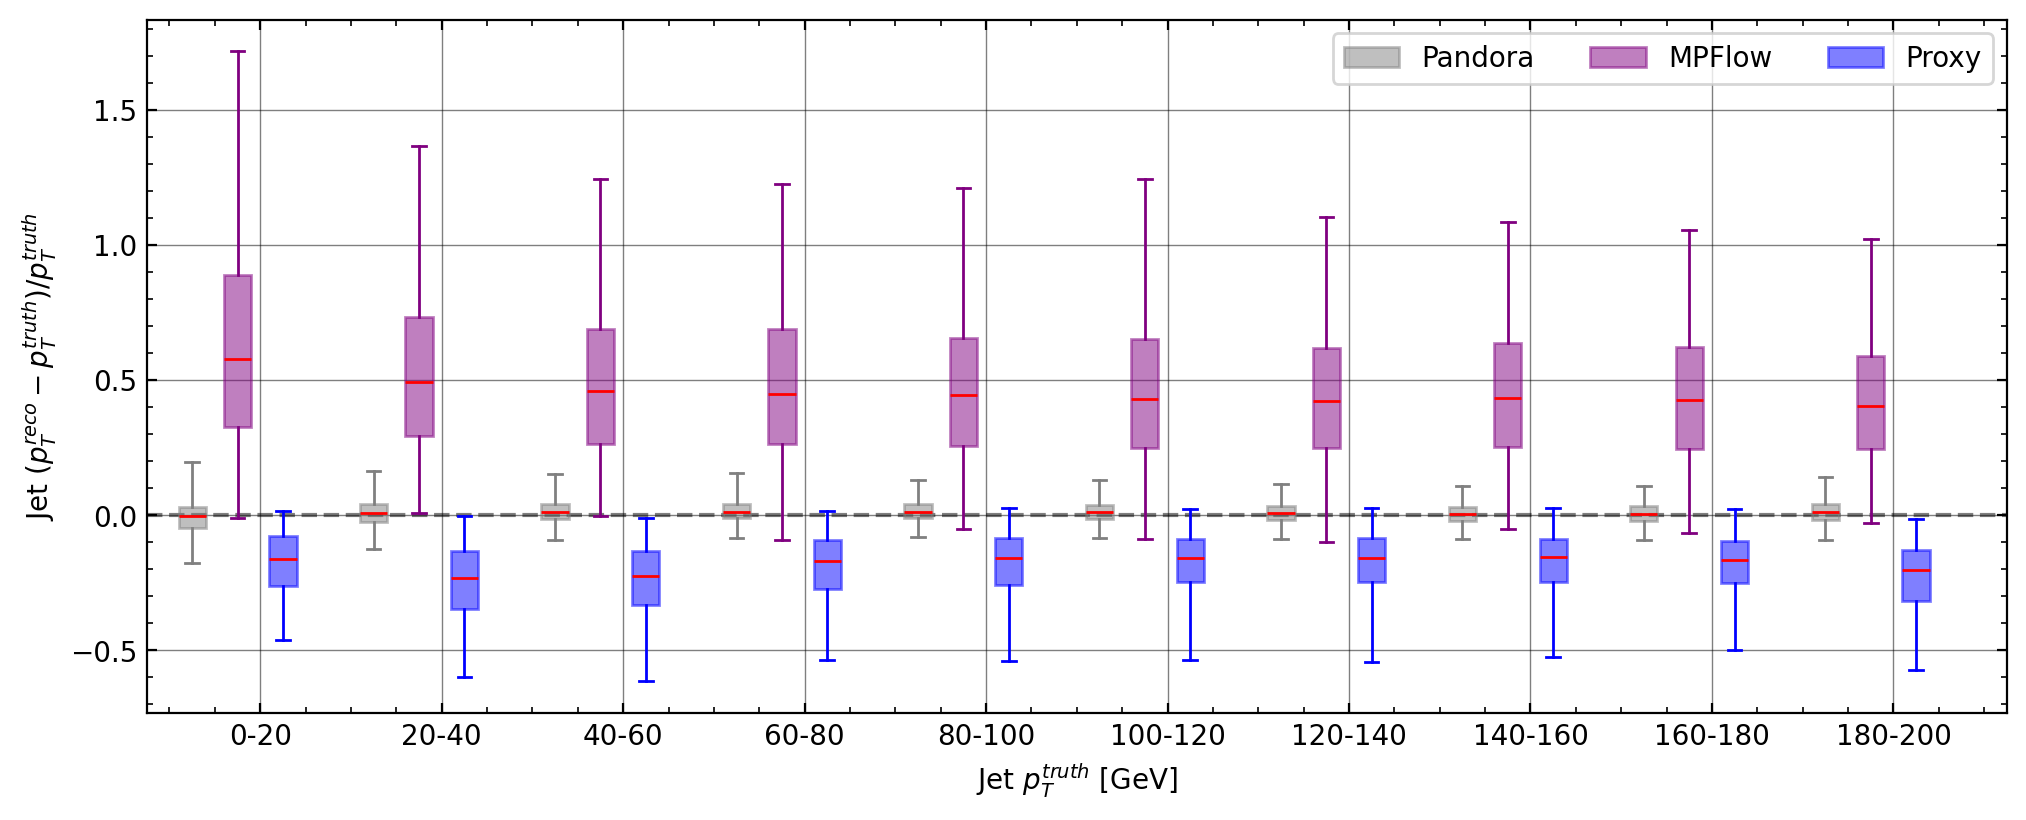

In [21]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_res_boxplot(jet_residual_dict, bins=pt_bins, var='pt')
if SAVE_FIG:
    fig.savefig(f'{save_dir}/clic_dijet_jet_residuals_boxplot_pt.png', dpi=300)

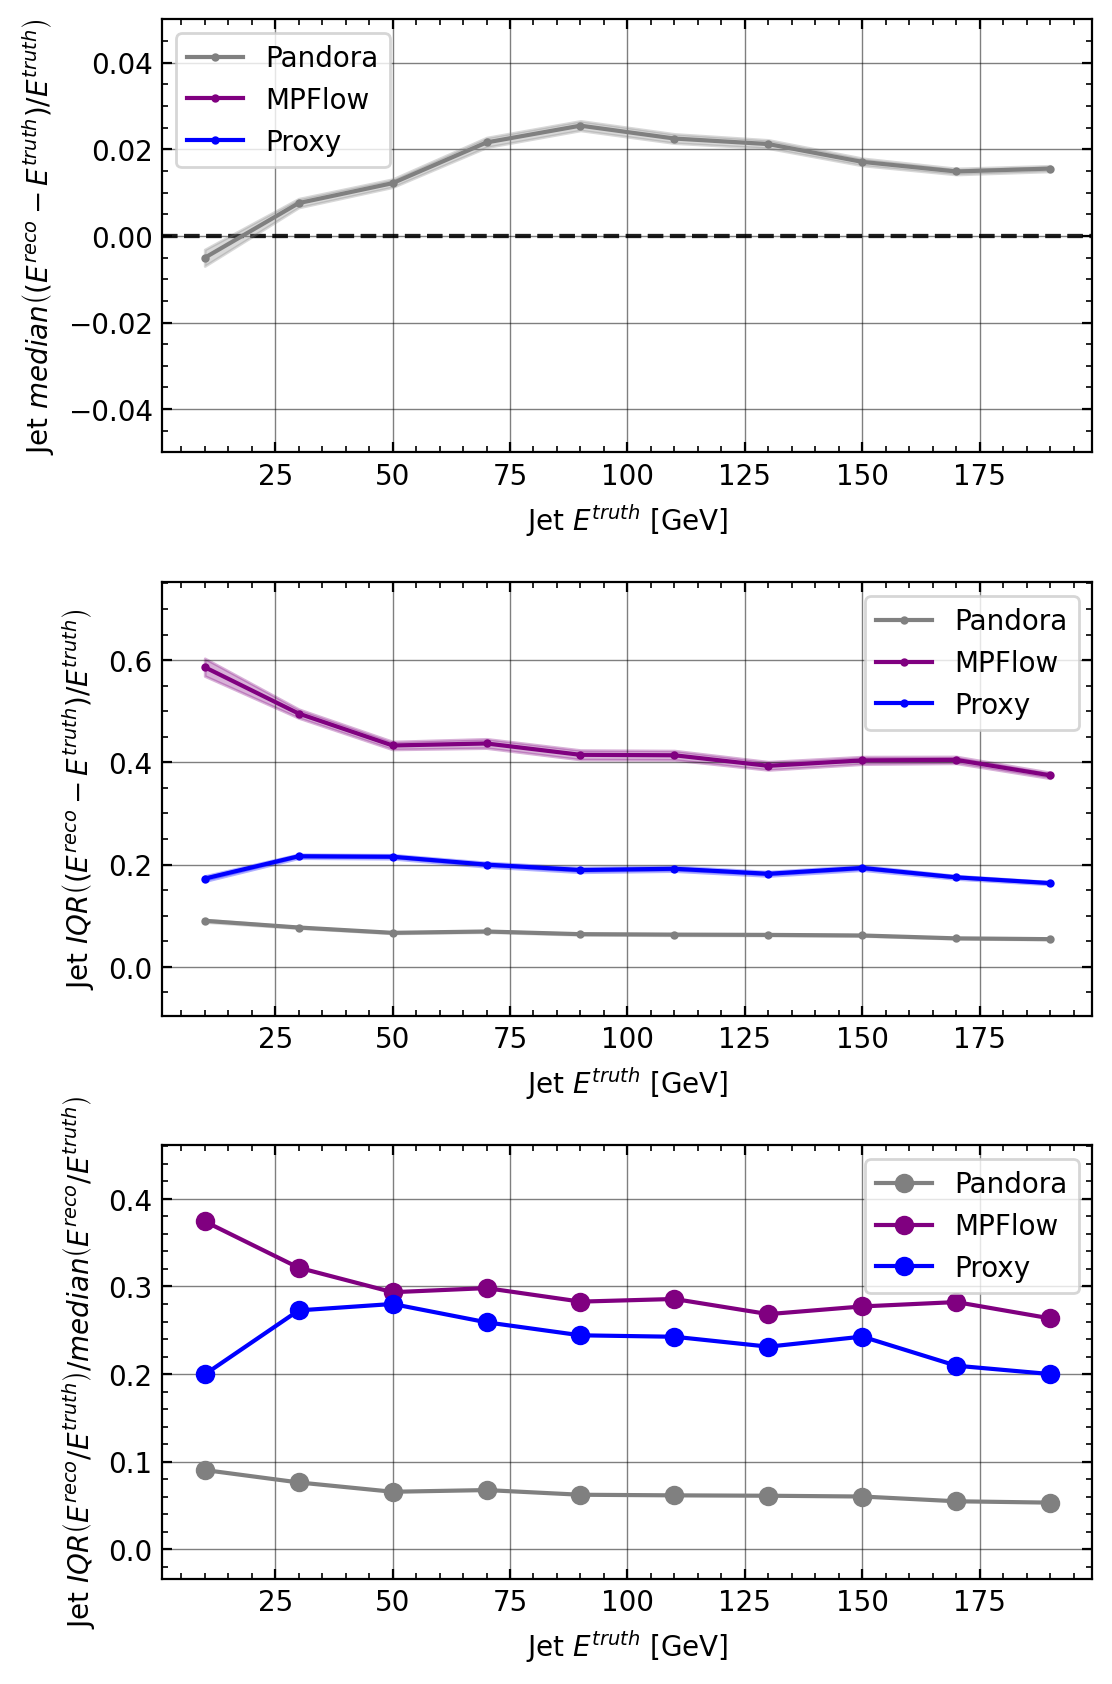

In [22]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_response(jet_residual_dict, pt_bins=pt_bins, use_energy=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(fig, list):
        for i, f in enumerate(fig):
            f.savefig(f'{save_dir}/clic_dijet_jet_response_boxplot_{i}.png', dpi=300)
    else:
        fig.savefig(f'{save_dir}/clic_dijet_jet_response_boxplot.png', dpi=300, bbox_inches='tight')

### jet marginal distributions

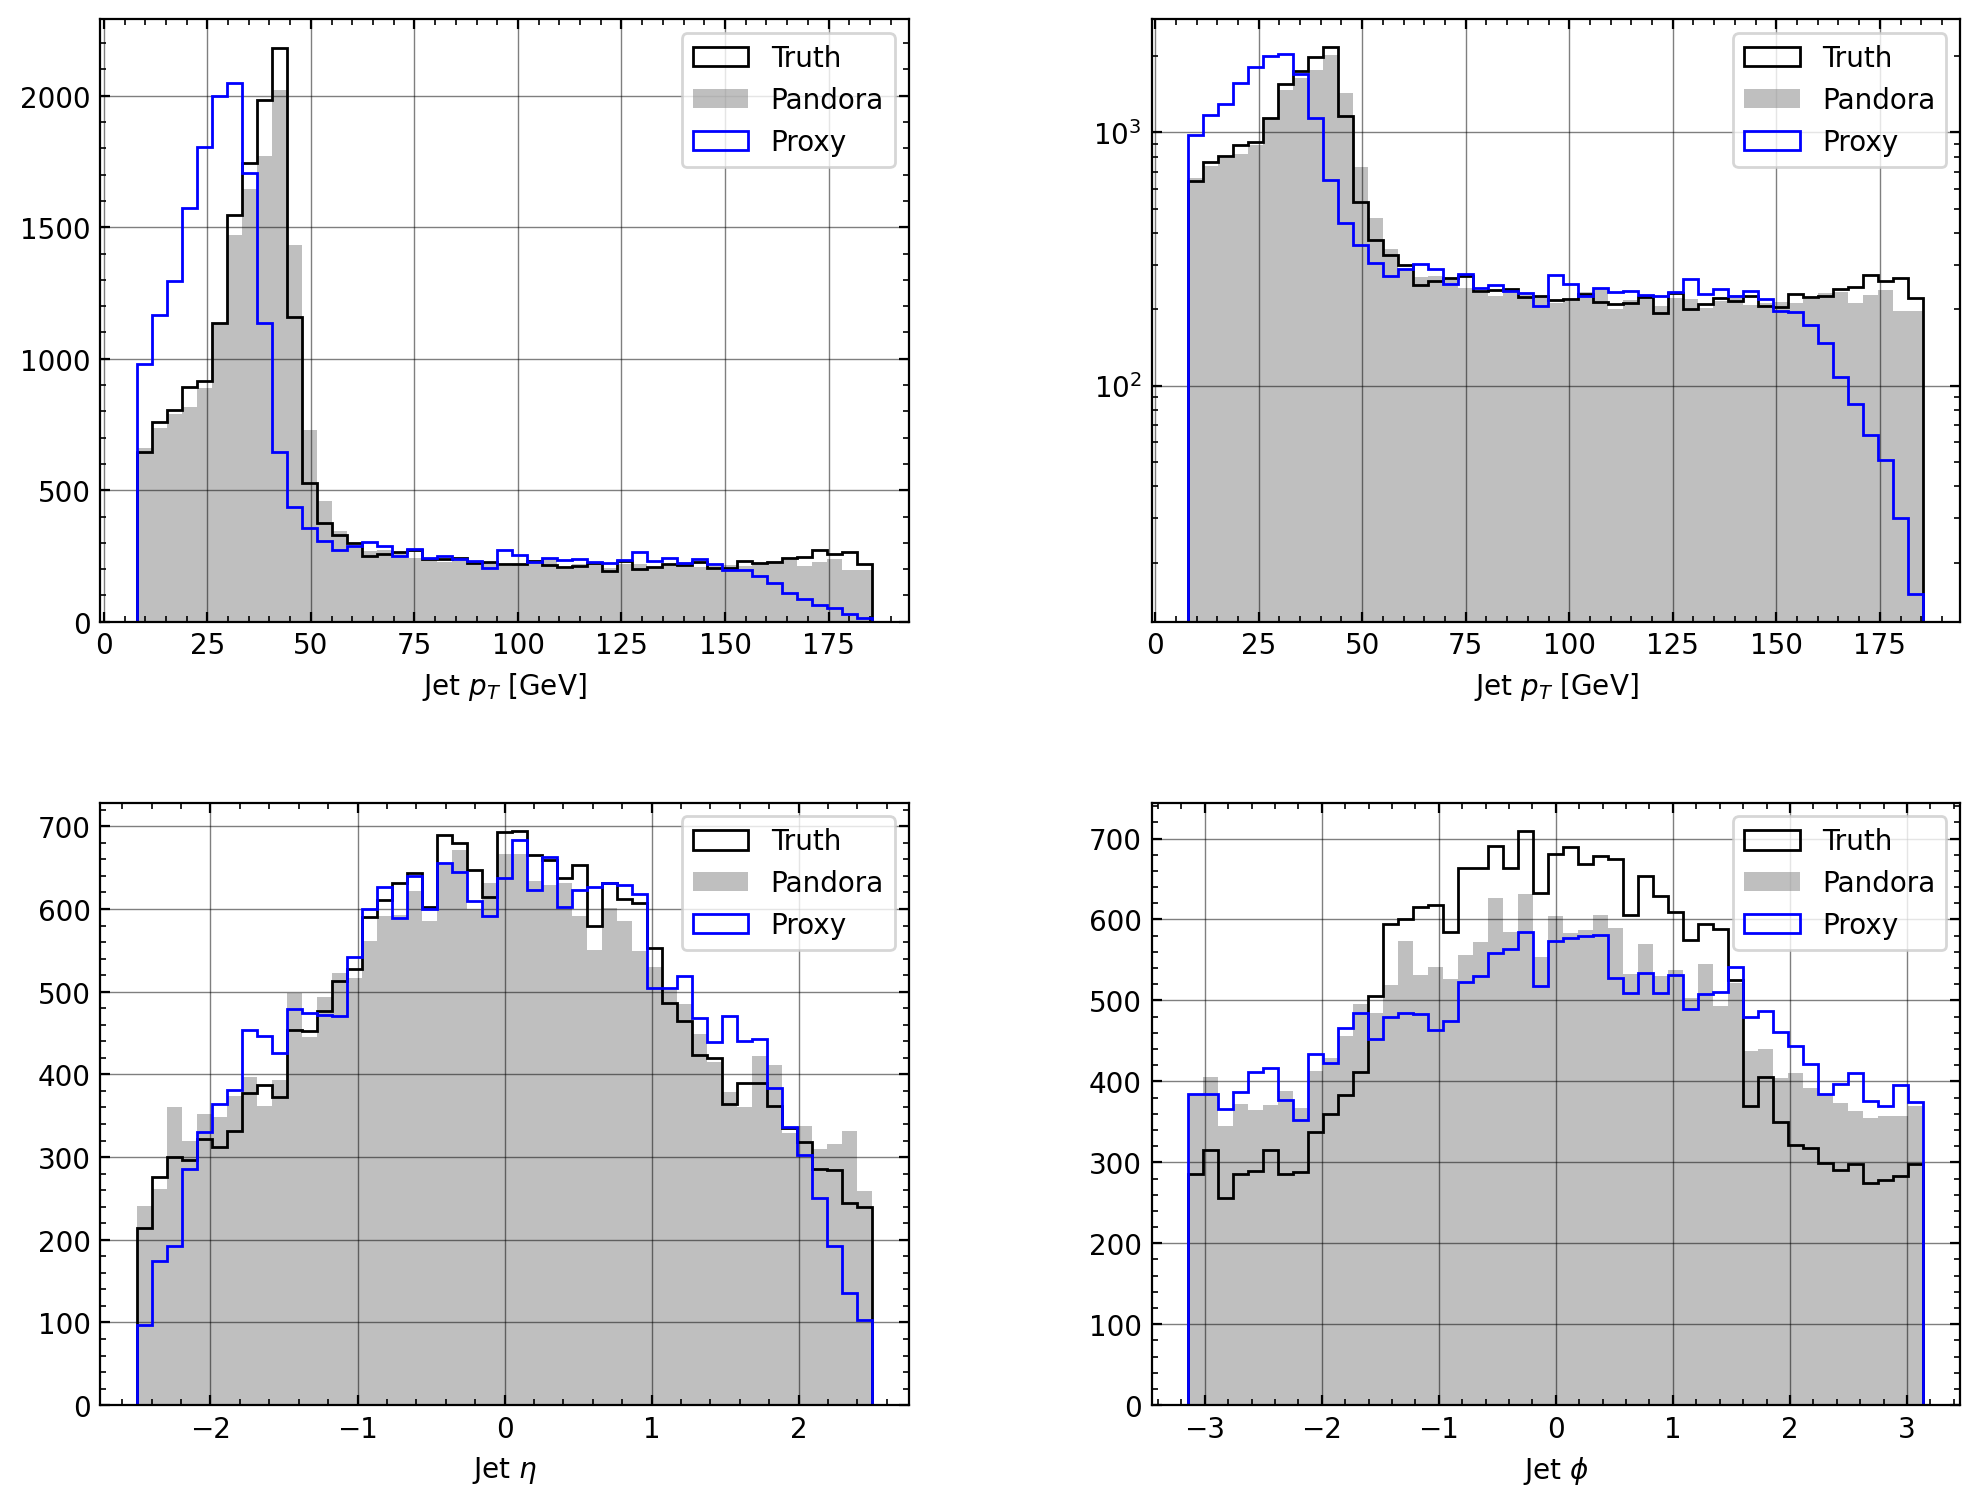

In [23]:
jet_dict = {
    'truth': perf_obj.truth_dict['truth_jets'],
    'pandora': perf_obj.truth_dict['pandora_jets'],
    # 'mlpf': perf_obj.mlpf_dict['jets'],
    # 'mpflow': perf_obj.data['mpflow']['jets'],
    'proxy': perf_obj.data['mpflow']['proxy_jets'],
    # 'hgpflow': perf_obj.data['hgpflow']['jets'],
}

fig = plot_jet_marginals(jet_dict, nleading=1, stylesheet=None)
if SAVE_FIG:
    fig.savefig(f'{save_dir}/clic_dijet_jet_marginals.png', dpi=300,bbox_inches='tight')

## Particle performance

In [35]:
perf_obj.hung_match_particles(flatten=True, return_unmatched=True)

Matching particles...: 100%|██████████| 9876/9876 [00:02<00:00, 4911.84it/s]


In [38]:
style_sheet_eff_fr = {
    'LINE_STYLES': {
        'proxy': '-',
        'hgpflow': '-.',
        'pandora': '--',
    },
    'COLORS': {
        'proxy': {
            'neut had': 'mediumseagreen',
            'photon': 'tomato',
        },
        'hgpflow': {
            'neut had': 'orange',
            'photon': 'darkorchid',
        },
        'pandora': {
            'neut had': 'dodgerblue',
            'photon': 'goldenrod',
        }
    }
}


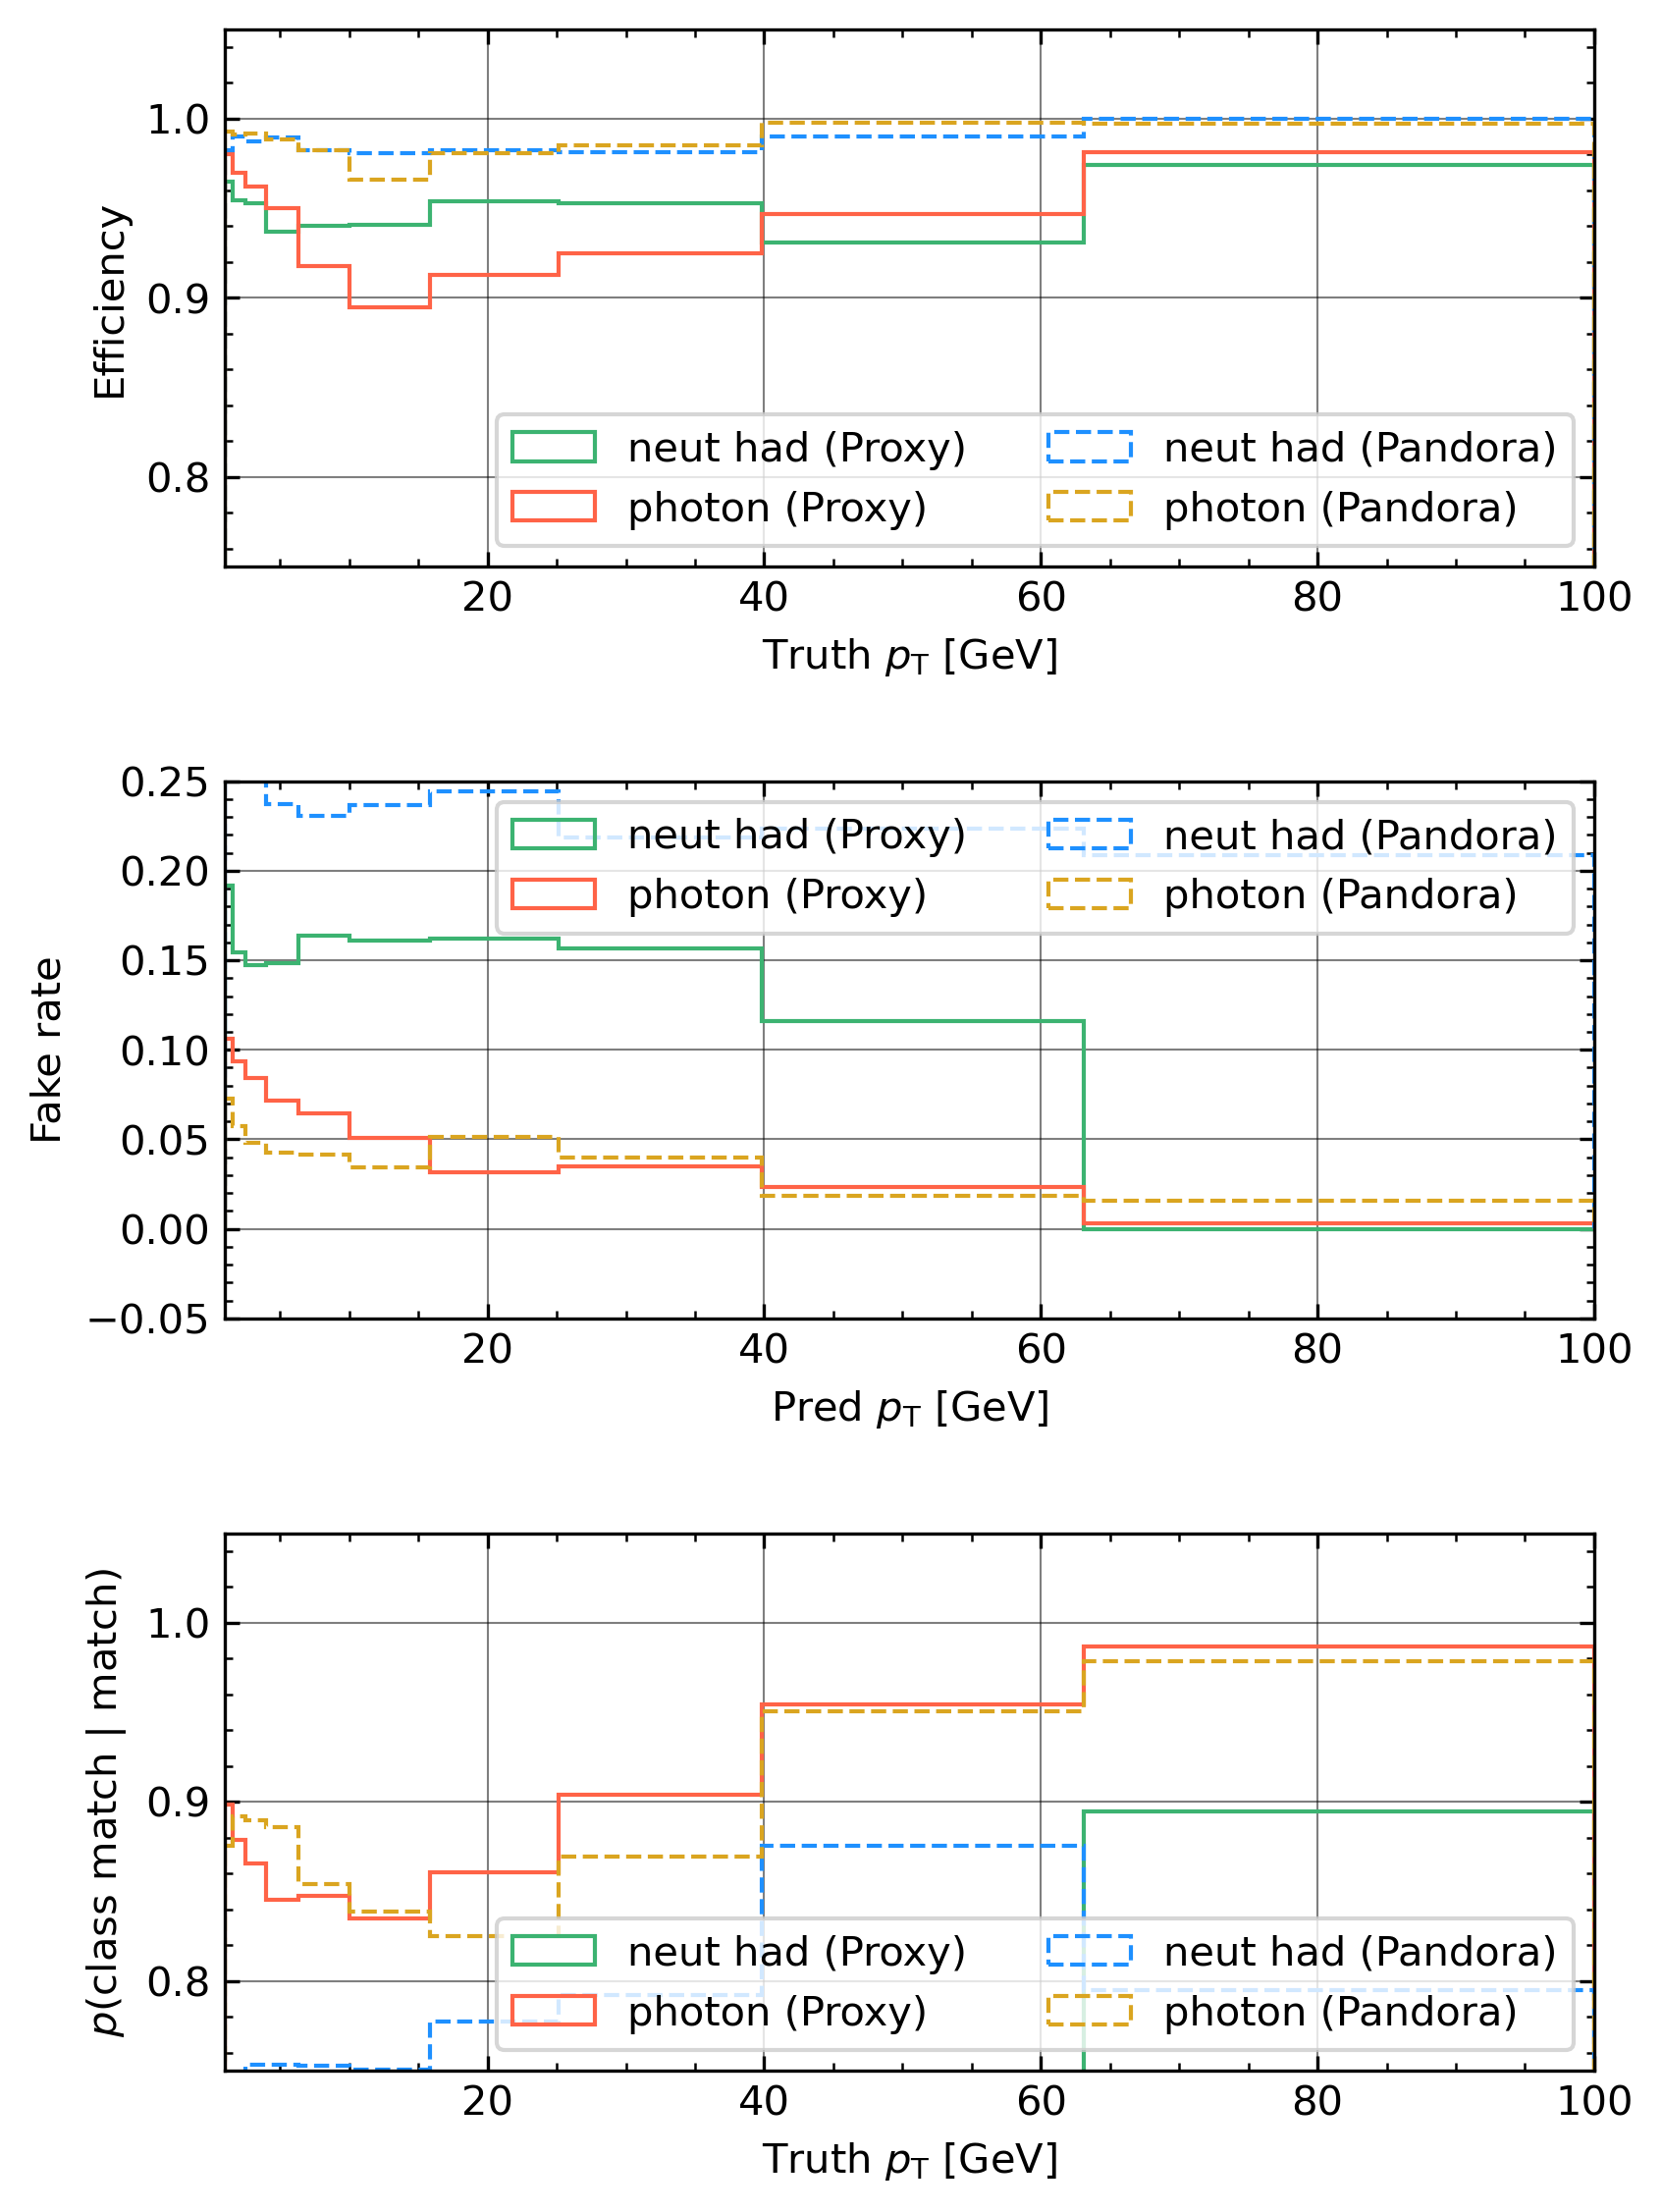

In [40]:
eff_fr_purity_input_dict = {
    'proxy': {
        'ref_matched': perf_obj.data['mpflow']['matched_proxy_particles'][0],
        'comp_matched': perf_obj.data['mpflow']['matched_proxy_particles'][1],
        'ref_unmatched': perf_obj.data['mpflow']['matched_proxy_particles'][2],
        'comp_unmatched': perf_obj.data['mpflow']['matched_proxy_particles'][3],
    },
    # 'hgpflow': {
    #     'ref_matched': perf_obj.data['hgpflow']['matched_particles'][0],
    #     'comp_matched': perf_obj.data['hgpflow']['matched_particles'][1],
    #     'ref_unmatched': perf_obj.data['hgpflow']['matched_particles'][2],
    #     'comp_unmatched': perf_obj.data['hgpflow']['matched_particles'][3],
    # },
    'pandora': {
        'ref_matched': perf_obj.truth_dict['matched_pandora_particles'][0],
        'comp_matched': perf_obj.truth_dict['matched_pandora_particles'][1],
        'ref_unmatched': perf_obj.truth_dict['matched_pandora_particles'][2],
        'comp_unmatched': perf_obj.truth_dict['matched_pandora_particles'][3],
    }
}

fig = plot_eff_fr_purity(eff_fr_purity_input_dict, stylesheet=style_sheet_eff_fr)
if SAVE_FIG:
    fig.savefig(f'{save_dir}/dijet_eff_fr_purity.png', dpi=300, bbox_inches='tight')

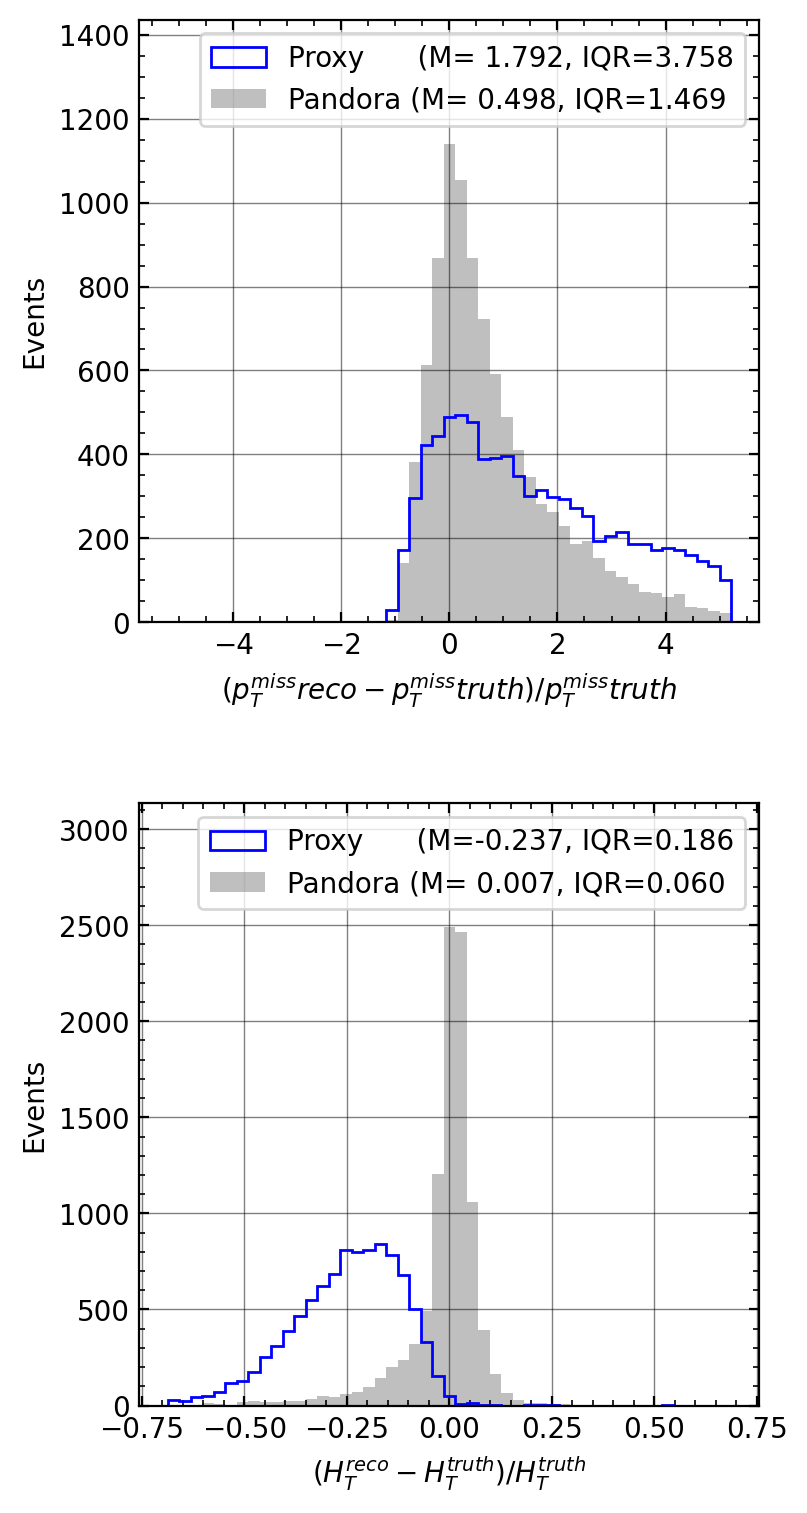

In [42]:
met_res_and_ht_res_input_dict = {
    "proxy" : [perf_obj.data['mpflow']['proxy_pt'], perf_obj.data['mpflow']['proxy_phi']],
    # "hgpflow": [perf_obj.data['hgpflow']['pt'], perf_obj.data['hgpflow']['phi']],
    'pandora': [perf_obj.truth_dict['pandora_pt'], perf_obj.truth_dict['pandora_phi']],
}
figs = plot_met_res_and_ht_res(perf_obj.truth_dict['particle_pt'], perf_obj.truth_dict['particle_phi'], met_res_and_ht_res_input_dict, stylesheet=None, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        for i, f in enumerate(figs):
            f.savefig(f'{save_dir}/clic_dijet_met_res_and_ht_res_{i}.png', dpi=300)
    else:
        figs.savefig(f'{save_dir}/clic_dijet_met_res_and_ht_res.png', dpi=300, bbox_inches='tight')

/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:135: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))
/tmp/ipykernel_559690/1318292195.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


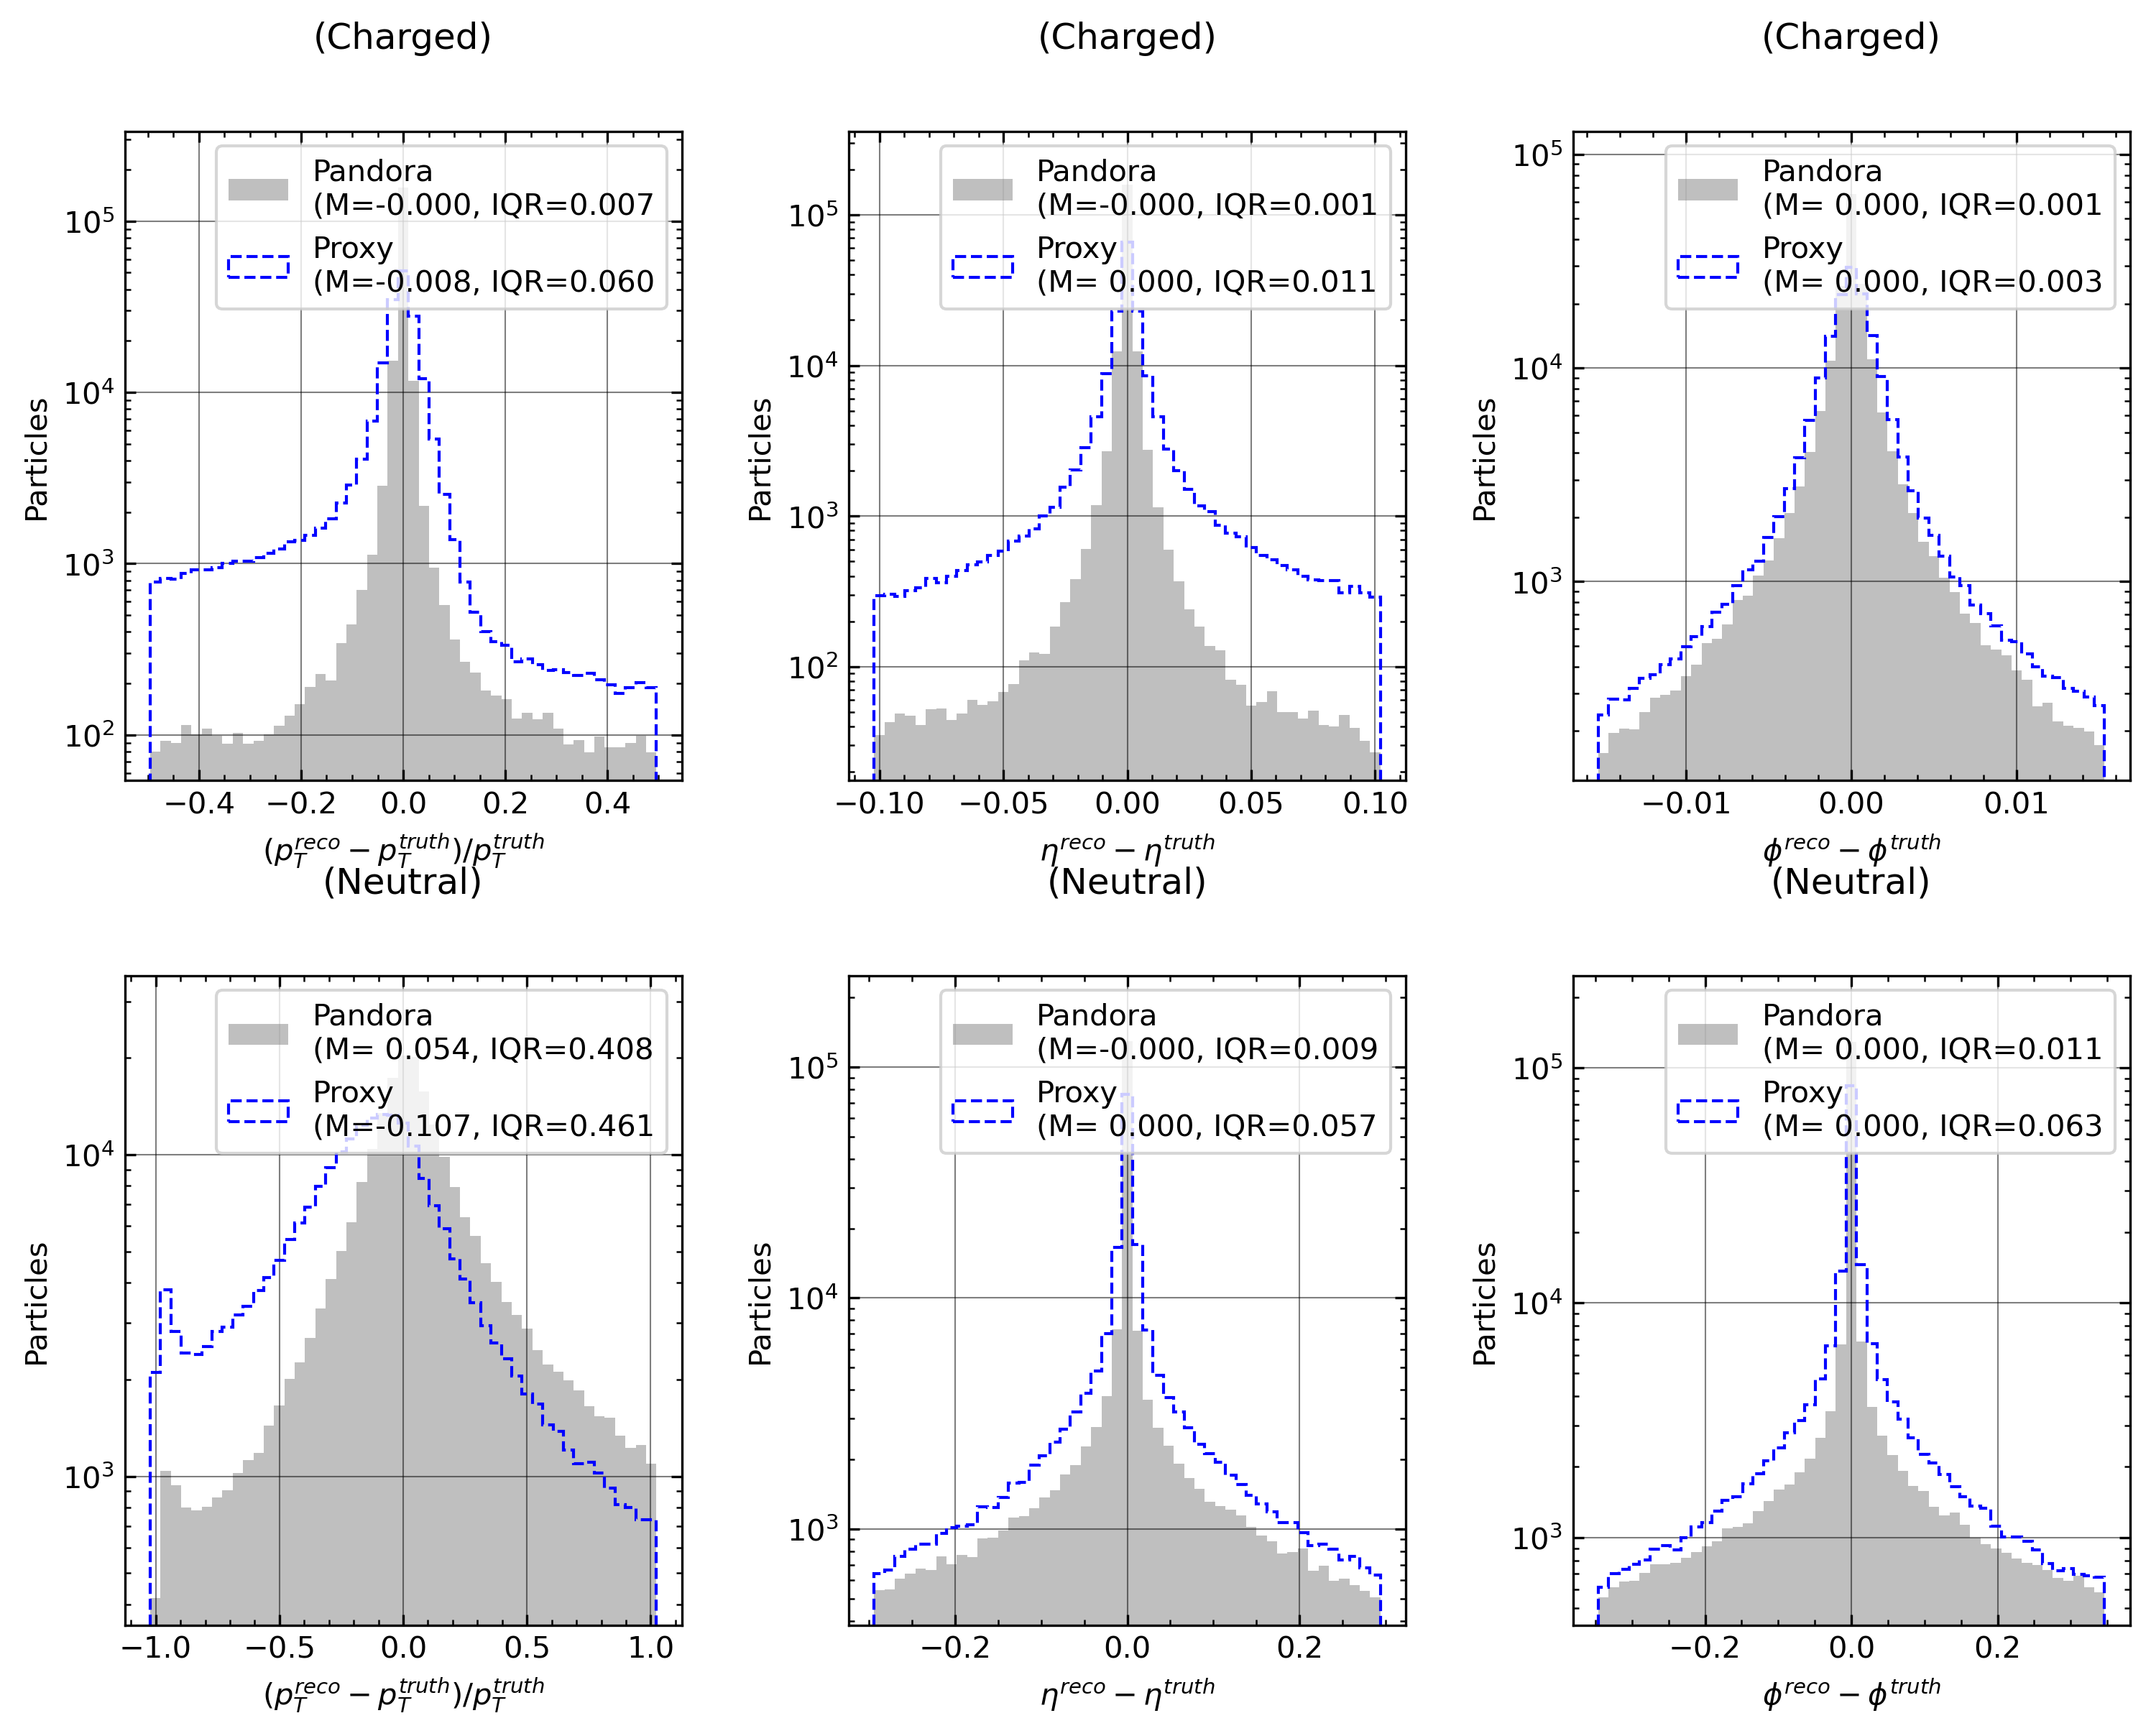

In [43]:
# from pflow.performance.plot_helper_particle import plot_residuals
from hepattn.experiments.clic.performance.style_sheet import LINE_STYLES

style_sheet_part_res = {
    'LINE_STYLES' : deepcopy(LINE_STYLES),
}
style_sheet_part_res['LINE_STYLES']['proxy'] = '--'
# style_sheet_part_res['COLORS']['proxy'] = 'dodgerblue'
# style_sheet_part_res['LINE_STYLES']['proxy'] = '-'

_dict = {
    'pandora': perf_obj.truth_dict['matched_pandora_particles'],
    # 'hgpflow': perf_obj.data['hgpflow']['matched_particles'],
    'proxy': perf_obj.data['mpflow']['matched_proxy_particles'],
}

qs = {
    'Charged': {'pt': 90, 'eta': 80, 'phi': 80}, 
    'Neutral': {'pt': 90, 'eta': 80, 'phi': 80}
}
fig = plot_residuals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=style_sheet_part_res)
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f'{save_dir}/dijet_particle_residuals.png', dpi=300, bbox_inches='tight')

In [44]:
_dict = {
    'proxy': perf_obj.data['mpflow']['matched_proxy_particles'],
    'pandora': perf_obj.truth_dict['matched_pandora_particles'],
    # 'hgpflow': perf_obj.data['hgpflow']['matched_particles'],
}

qs = {
    'Neutral hadron': {'pt': 98, 'eta': 75, 'phi': 75}, 
    'Photon': {'pt': 99, 'eta': 90, 'phi': 90}
}
figs = plot_residuals_neutrals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=None, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f'{save_dir}/dijet_particle_residuals_neutralhad_pt.png', dpi=300, bbox_inches='tight')
        figs[1].savefig(f'{save_dir}/dijet_particle_residuals_neutralhad_eta.png', dpi=300, bbox_inches='tight')
        figs[2].savefig(f'{save_dir}/dijet_particle_residuals_neutralhad_phi.png', dpi=300, bbox_inches='tight')
        figs[3].savefig(f'{save_dir}/dijet_particle_residuals_photon_pt.png', dpi=300, bbox_inches='tight')
        figs[4].savefig(f'{save_dir}/dijet_particle_residuals_photon_eta.png', dpi=300, bbox_inches='tight')
        figs[5].savefig(f'{save_dir}/dijet_particle_residuals_photon_phi.png', dpi=300, bbox_inches='tight')
    else:
        figs.savefig(f'{save_dir}/dijet_particle_residuals_neutralhad_photon.png', dpi=300, bbox_inches='tight')

/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:234: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))


In [45]:
perf_obj.hung_match_particles(flatten=False, return_unmatched=True)

Matching particles...: 100%|██████████| 9876/9876 [00:01<00:00, 5198.02it/s]


In [46]:
import matplotlib.pyplot as plt

In [47]:
def plot_matched_event(idx):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    ref_class = perf_obj.data['mpflow']['matched_proxy_particles'][0]['class'][idx]
    comp_class = perf_obj.data['mpflow']['matched_proxy_particles'][1]['class'][idx]
    comp_class_hgpf = perf_obj.data['mpflow']['matched_particles'][1]['class'][idx]
    ax.scatter(
        perf_obj.data['mpflow']['matched_proxy_particles'][0]['phi'][idx][ref_class < 3],
        perf_obj.data['mpflow']['matched_proxy_particles'][0]['eta'][idx][ref_class < 3],
        marker='o', s=20, color='blue', label='Truth'
    )
    ax.scatter(
        perf_obj.data['mpflow']['matched_proxy_particles'][1]['phi'][idx][comp_class < 3],
        perf_obj.data['mpflow']['matched_proxy_particles'][1]['eta'][idx][comp_class < 3],
        marker='x', s=20, color='orange', label='Proxy'
    )
    ax.scatter(
        perf_obj.data['mpflow']['matched_particles'][1]['phi'][idx][comp_class_hgpf < 3],
        perf_obj.data['mpflow']['matched_particles'][1]['eta'][idx][comp_class_hgpf < 3],
        marker='^', s=20, color='red', label='MPflow', alpha=0.5
    )
    fig.suptitle(f'Event {idx}')
    ax.set_xlabel('Phi')
    ax.set_ylabel('Eta')
    fig.legend()
    fig.tight_layout()
    fig.show()

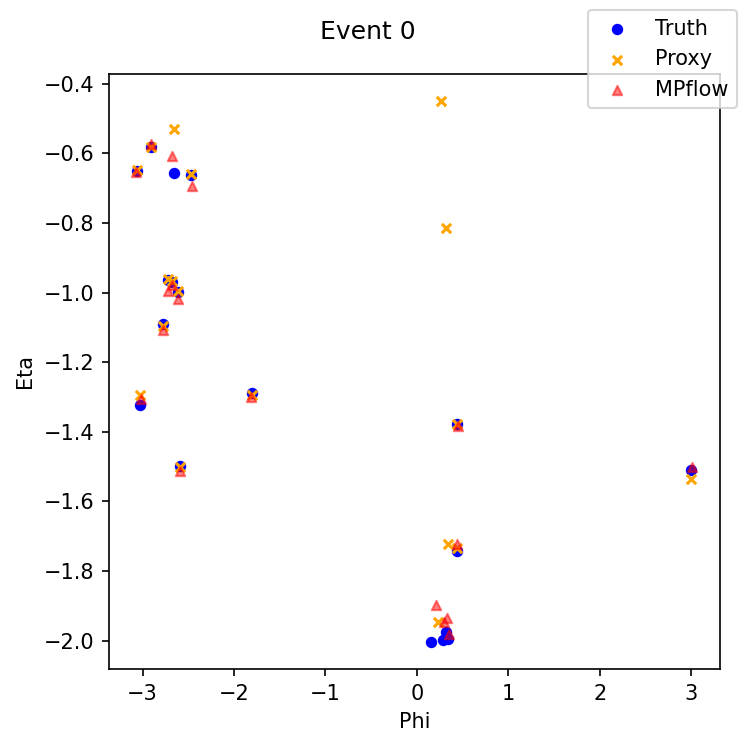

In [49]:
plot_matched_event(0)